<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/ML%20autogluon%20multimodal%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install AutoGluon (Run this first)
# This cell installs AutoGluon and its multimodal components.
# It might take a few minutes.

import sys
import os

# Install AutoGluon Multimodal (This includes core and tabular dependencies)
# Using --no-deps can sometimes help avoid dependency conflicts,
# but AutoGluon usually manages its dependencies well.
# The --quiet flag reduces output noise during installation.
!pip install autogluon.multimodal --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 5.7 MB/s eta 0:00:00
  

In [2]:

# It's good practice to restart the runtime after installation
# to ensure all packages are loaded correctly.
# print("Please restart the runtime after installation completes.")
# print("Go to Runtime -> Restart Runtime in Colab menu.")
# sys.exit() # Uncomment if you want the cell to explicitly stop here.

# After restart, you can run the rest of the code.
print("AutoGluon Multimodal installed successfully. You may need to restart the runtime.")

# %%
# @title Import Libraries and Set Seeds
import os
import numpy as np
import pandas as pd
import warnings
from autogluon.multimodal import MultiModalPredictor

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# Set seed for reproducibility
np.random.seed(123)
print("Libraries imported and seeds set.")

AutoGluon Multimodal installed successfully. You may need to restart the runtime.
Libraries imported and seeds set.


Data Preparation (train_data and test_data):
The train_data DataFrame (and test_data) contains multiple columns.

**Tabular Data**: Columns like Type, Age, Breed1, Breed2, Gender, Color1, Color2, Color3, MaturitySize, FurLength, Vaccinated, Dewormed, Sterilized, Health, Quantity, Fee, State, VideoAmt, PhotoAmt are numerical or categorical values. AutoGluon treats these as tabular features.

**Text Data:** The Description column contains free-form text descriptions of the pets. AutoGluon identifies this column as text data and uses text processing models (like transformers) to handle it.

**Image Data:** The Images column contains file paths (or potentially URLs) pointing to the actual image files. AutoGluon recognizes these paths and uses computer vision models (like CNNs) to process the image content.

In [3]:
# @title Download and Prepare the PetFinder Dataset
# This dataset contains images, text descriptions, and tabular features
# for pets, with the goal of predicting adoption speed.

download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'

# Download and extract the dataset
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

# Load the training and testing data
dataset_path = os.path.join(download_dir, 'petfinder_for_tutorial')
train_data = pd.read_csv(os.path.join(dataset_path, 'train.csv'), index_col=0)
test_data = pd.read_csv(os.path.join(dataset_path, 'test.csv'), index_col=0)

label_col = 'AdoptionSpeed' # The column to predict
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Label column: {label_col}")

100%|██████████| 18.8M/18.8M [00:00<00:00, 22.6MiB/s]


Training data shape: (600, 25)
Test data shape: (100, 25)
Label column: AdoptionSpeed


In [4]:
# %%
# @title Expand Image Paths
# The image paths in the CSV are relative; we need absolute paths for the model to read them.
image_col = 'Images'

# Use only the first image if multiple are listed per pet
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0] if ele and ';' in ele else ele)
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0] if ele and ';' in ele else ele)

def path_expander(path, base_folder):
    # Ensure the path is an absolute path relative to the base folder
    if pd.isna(path) or path == '':
        return path # Handle missing paths gracefully if necessary
    return os.path.abspath(os.path.join(base_folder, path))

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

print(f"First training image path: {train_data[image_col].iloc[0]}")
print(f"First test image path: {test_data[image_col].iloc[0]}")

First training image path: /content/ag_automm_tutorial/petfinder_for_tutorial/images/7d7a39d71-1.jpg
First test image path: /content/ag_automm_tutorial/petfinder_for_tutorial/images/9bd0992bc-1.jpg



--- Example Training Row ---
Type                                                             2
Name                                                        Mattie
Age                                                             12
Breed1                                                         266
Breed2                                                           0
Gender                                                           2
Color1                                                           1
Color2                                                           7
Color3                                                           0
MaturitySize                                                     2
FurLength                                                        1
Vaccinated                                                       1
Dewormed                                                         1
Sterilized                                                       1
Health                          

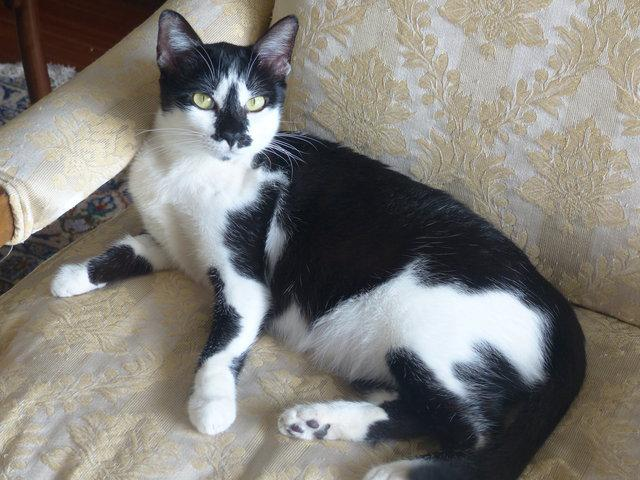

In [5]:
# %%
# @title Inspect Sample Data
# Let's look at an example row to understand the data structure.
example_row = train_data.iloc[2]
print("\n--- Example Training Row ---")
print(example_row)
print("\n--- Text Description for Example Row ---")
print(example_row['Description'])

# Optional: Display the image (if available)
try:
    from IPython.display import Image as IPImage, display
    example_image_path = example_row[image_col]
    if os.path.exists(example_image_path):
        print("\n--- Image for Example Row ---")
        display(IPImage(filename=example_image_path, width=200, height=200))
    else:
        print(f"\n--- Image file not found: {example_image_path} ---")
except ImportError:
    print("IPython not available for image display in this environment.")

In [10]:
# %%
# @title Define Hyperparameters (Optional) - Using Default Behavior
# The MultiModalPredictor often works well with default settings.
# You can specify hyperparameters directly in the fit method if needed,
# but the presets functionality might be integrated differently now.
# For example, you can pass arguments like presets="medium_quality" directly to fit().

# Define the predictor
predictor = MultiModalPredictor(label=label_col)

# Fit the model. Adjust time_limit based on your needs and computational resources.
# A higher time limit often leads to better performance.
# Using presets="medium_quality" directly in fit()
fit_results = predictor.fit(
    train_data=train_data,
    time_limit=120, # Train for 60 seconds as an example
    presets="medium_quality", # Use the preset directly here
    # You can add other arguments like tuning_data for validation split if needed
)
print("\nTraining completed.")
# The fit_results might contain information, but the primary model is stored in 'predictor'
# print(f"Fit results: {fit_results}") # This might not always contain a 'best_score' key

# %%
# @title Evaluate the Model on Test Data
# Evaluate the trained model's performance.
# Common metrics for classification include 'accuracy', 'roc_auc', 'f1', 'precision', 'recall'.
# Note: 'roc_auc' might require prediction probabilities for binary classification.
scores = predictor.evaluate(test_data, metrics=['accuracy', 'roc_auc'])
print("\n--- Evaluation Results on Test Data ---")
print(scores)

# %%
# @title Make Predictions on Test Data (Without Labels)
# Predict the AdoptionSpeed for the test set.
test_features = test_data.drop(columns=[label_col])
predictions = predictor.predict(test_features)
print("\n--- First 5 Predictions ---")
print(predictions.head())

# %%
# @title Get Prediction Probabilities (For Classification Tasks)
# Get the probability of each class for the test set.
# This is useful for understanding model confidence.
probas = predictor.predict_proba(test_features)
print("\n--- First 5 Prediction Probabilities ---")
print(probas.head())

# %%
# @title Extract Embeddings (Optional)
# Extract feature embeddings for the test data.
# These can be used for downstream tasks like clustering or custom models.
embeddings = predictor.extract_embedding(test_features)
print(f"\n--- Embedding Shape for Test Data ---")
print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding for first sample (first 10 values): {embeddings[0][:10]}")

No path specified. Models will be saved in: "AutogluonModels/ag-20251012_190434"
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Sep  6 09:54:41 UTC 2025
CPU Count:          2
Pytorch Version:    2.7.1+cu126
CUDA Version:       CUDA is not available
GPU Count:          0
Memory Avail:       8.81 GB / 12.67 GB (69.5%)
Disk Space Avail:   62.02 GB / 107.72 GB (57.6%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [np.int64(0), np.int64(1)]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:02:01. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 1: 'val_roc_auc' reached 0.55389 (best 0.55389), saving model to '/content/AutogluonModels/ag-20251012_190434/epoch=0-step=1.ckpt' as top 3
AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20251012_190434")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



Training completed.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



--- Evaluation Results on Test Data ---
{'accuracy': 0.51, 'roc_auc': np.float64(0.5147999999999999)}


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



--- First 5 Predictions ---
8     0
70    1
82    0
28    0
63    0
Name: AdoptionSpeed, dtype: int64


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



--- First 5 Prediction Probabilities ---
           0         1
8   0.977469  0.022531
70  0.379573  0.620427
82  0.826801  0.173199
28  0.944785  0.055215
63  0.832581  0.167419


Predicting: |          | 0/? [00:00<?, ?it/s]


--- Embedding Shape for Test Data ---
Embeddings shape: (100, 128)
Embedding for first sample (first 10 values): [ 0.22191647 -0.00836859 -0.00422861 -0.01541746  1.3590103  -0.02572576
  1.8504361   1.4963634   0.2261411  -0.00292946]



--- Evaluating Prediction Quality ---


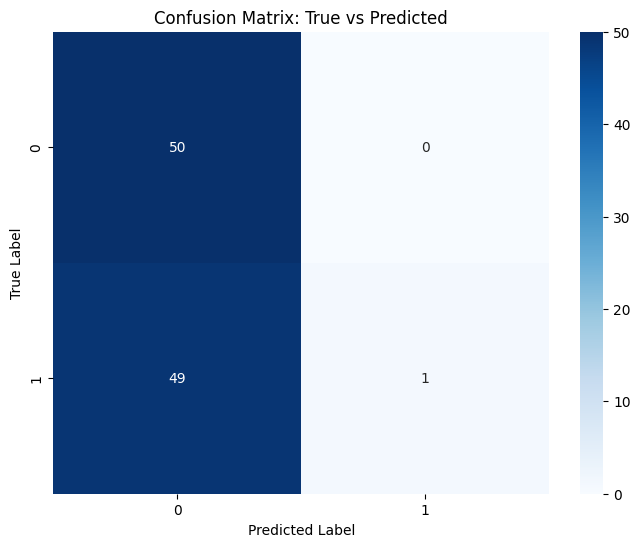


--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        50
           1       1.00      0.02      0.04        50

    accuracy                           0.51       100
   macro avg       0.75      0.51      0.36       100
weighted avg       0.75      0.51      0.36       100


--- Manually Calculated Metrics (for binary case, assuming class 1 is positive) ---
Accuracy (from sklearn calculation): 0.5100
Precision (Positive Class): 1.0000
Recall (Positive Class) / Sensitivity: 0.0200
F1-Score (Positive Class): 0.0392
Specificity (Negative Class): 1.0000

--- Comparison with AutoGluon's evaluate() ---
AutoGluon Accuracy: 0.5100
AutoGluon ROC-AUC: 0.5148


In [11]:
# %%
# @title Evaluate Prediction Quality: Confusion Matrix and Other Metrics
# This section demonstrates how to assess the quality of the predictions using a confusion matrix
# and other common classification metrics.
print("\n--- Evaluating Prediction Quality ---")

# Import necessary libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels from the test data
true_labels = test_data[label_col]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(true_labels.unique()), yticklabels=sorted(true_labels.unique()))
plt.title('Confusion Matrix: True vs Predicted')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print a detailed classification report
print("\n--- Detailed Classification Report ---")
print(classification_report(true_labels, predictions))

# Calculate and print some additional common metrics based on the confusion matrix
tn = cm[0, 0] # True Negatives (assuming class 0 is negative)
fp = cm[0, 1] # False Positives
fn = cm[1, 0] # False Negatives
tp = cm[1, 1] # True Positives (assuming class 1 is positive)

accuracy_sklearn = (tp + tn) / (tp + tn + fp + fn)
precision_sklearn = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_sklearn = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_sklearn = 2 * (precision_sklearn * recall_sklearn) / (precision_sklearn + recall_sklearn) if (precision_sklearn + recall_sklearn) > 0 else 0

print(f"\n--- Manually Calculated Metrics (for binary case, assuming class 1 is positive) ---")
print(f"Accuracy (from sklearn calculation): {accuracy_sklearn:.4f}")
print(f"Precision (Positive Class): {precision_sklearn:.4f}")
print(f"Recall (Positive Class) / Sensitivity: {recall_sklearn:.4f}")
print(f"F1-Score (Positive Class): {f1_sklearn:.4f}")
# Specificity
specificity_sklearn = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"Specificity (Negative Class): {specificity_sklearn:.4f}")

# Compare with the score obtained from the predictor.evaluate function
print(f"\n--- Comparison with AutoGluon's evaluate() ---")
print(f"AutoGluon Accuracy: {scores['accuracy']:.4f}")
# Note: AutoGluon's 'roc_auc' might differ slightly depending on the exact calculation method used.
# The sklearn report provides Precision, Recall, F1 per class and macro/micro averages.
print(f"AutoGluon ROC-AUC: {scores['roc_auc']:.4f}")

In [8]:
# %%
# @title Save and Load the Trained Model
# Save the trained model for later use.
import uuid
model_path = f"./tmp/{uuid.uuid4().hex}-saved_model"
os.makedirs(os.path.dirname(model_path), exist_ok=True) # Ensure directory exists

predictor.save(path=model_path)
print(f"\nModel saved to: {model_path}")

# Load the model back
loaded_predictor = MultiModalPredictor.load(path=model_path)
print(f"Model loaded from: {model_path}")

# Verify loaded model works by evaluating again
scores_loaded = loaded_predictor.evaluate(test_data, metrics=['roc_auc'])
print(f"Evaluation score of loaded model: {scores_loaded}")

# Clean up saved model directory if needed
# import shutil
# shutil.rmtree(model_path)
print("\nModel saving and loading example completed.")


Model saved to: ./tmp/4170e334557a425bbfa5a9baecf7c032-saved_model


Load pretrained checkpoint: /content/tmp/4170e334557a425bbfa5a9baecf7c032-saved_model/model.ckpt
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Model loaded from: ./tmp/4170e334557a425bbfa5a9baecf7c032-saved_model


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation score of loaded model: {'roc_auc': np.float64(0.5352)}

Model saving and loading example completed.
